# Prediction of Gold Recovery Ratio from Gold Ore

provided data with the parameters of extraction and purification of gold from ore

**TASK:** to prepare a prototype machine learning model for a company that develops solutions for the efficient operation of industrial enterprises and predict the recovery rate of gold from gold ore. the model should help optimize production so as not to launch an enterprise with unprofitable characteristics.

**Recovery** is calculated using the formula:

$$ Recovery = \frac{C * (F - T)}{F * (C - T)} * 100\% $$

where:
- C is the proportion of gold in the concentrate after flotation/refining
- F is the share of gold in the raw material/concentrate before flotation/refining
- T is the share of gold in final tailings after flotation/cleaning

**quality metric** - sMAPE (Symmetric Mean Absolute Percentage Error)

it is necessary to predict the values:
- rough concentrate enrichment efficiency rougher.output.recovery
- efficiency of final concentrate final.output.recovery

final metric: final_sMAPE = 25% * sMAPE(rougher) + 75% * sMAPE(final)

**Key skills and tools:** exploratory data analysis, data visualization, 
- Pandas, Sklearn

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span><ul class="toc-item"><li><span><a href="#concentration-of-metals" data-toc-modified-id="concentration-of-metals-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>concentration of metals</a></span></li><li><span><a href="#size-distribution-of-raw-material-granules" data-toc-modified-id="size-distribution-of-raw-material-granules-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>size distribution of raw material granules</a></span><ul class="toc-item"><li><span><a href="#rougher-stage" data-toc-modified-id="rougher-stage-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>rougher stage</a></span></li><li><span><a href="#primary_cleaner-stage" data-toc-modified-id="primary_cleaner-stage-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>primary_cleaner stage</a></span></li></ul></li><li><span><a href="#total-concentration-of-all-substances" data-toc-modified-id="total-concentration-of-all-substances-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>total concentration of all substances</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#model-selection" data-toc-modified-id="model-selection-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>model selection</a></span></li><li><span><a href="#model-testing" data-toc-modified-id="model-testing-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>model testing</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Data preprocessing

In [1]:
# DA
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats as st

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

# options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

In [2]:
# fix RandomState
STATE = np.random.RandomState(12345)

**Data Description:**

Technological process:
- Rougher feed - feedstock
- Rougher additions (or reagent additions) - flotation reagents: Xanthate, Sulphate, Depressant
    - Xanthate ** - xanthate (promoter, or flotation activator);
    - Sulphate - sulfate (in this production, sodium sulfide);
    - Depressant - depressant (sodium silicate).
- Rougher process - flotation
- Rougher tails - rougher tails
- Float banks - flotation unit
- Cleaner process - cleaning
- Rougher Au - rough gold concentrate
- Final Au - final gold concentrate

Stage parameters:
- air amount — air volume
- fluid levels - fluid level
- feed size - feed granule size
- feed rate - feed rate

*Feature name:* [stage].[parameter_type].[parameter_name]

Possible values for block [stage]:
- `rougher` - flotation
- `primary_cleaner` - primary cleaning
- `secondary_cleaner ` - secondary cleaning
- `final`—final characteristics

Possible values for block [parameter_type]:
- `input`— raw material parameters
- `output ` - product parameters
- `state` — parameters characterizing the current state of the stage
- `calculation` — calculated characteristics

The data is in three files:
- gold_recovery_train.csv - training sample;
- gold_recovery_test.csv - test sample;
- gold_recovery_full.csv - initial data.

The data is indexed by the date and time the information was received (the date attribute).
Parameters adjacent in time are often similar.
Some parameters are not available because they are measured and/or calculated much later. Because of this, the test set lacks some features that may be in the training set. Also, there are no target features in the test set.
The initial dataset contains the training and test sets with all features.

In [3]:
# make a function that describes df
def describe_func(df):
    print('\ndata type')
    display(df.info())
    print('\nmissing values, %')
    display(df.isna().mean()*100)
    print('\nduplicated')
    print(df.duplicated().sum())

In [4]:
# load and study the train df
df_train = pd.read_csv('data/gold_recovery_train.csv', sep=',', index_col = 'date')
df_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [5]:
describe_func(df_train)


data type
<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                  

None


missing values, %


final.output.concentrate_ag                            0.007068
final.output.concentrate_pb                            0.007068
final.output.concentrate_sol                           1.491271
final.output.concentrate_au                            0.000000
final.output.recovery                                  0.000000
final.output.tail_ag                                   0.000000
final.output.tail_pb                                   0.706764
final.output.tail_sol                                  0.035338
final.output.tail_au                                   0.000000
primary_cleaner.input.sulfate                          0.141353
primary_cleaner.input.depressant                       0.226164
primary_cleaner.input.feed_size                        0.000000
primary_cleaner.input.xanthate                         0.706764
primary_cleaner.output.concentrate_ag                  0.000000
primary_cleaner.output.concentrate_pb                  0.607817
primary_cleaner.output.concentrate_sol  


duplicated
0


In [6]:
# # load and study the test df
df_test = pd.read_csv('data/gold_recovery_test.csv', sep=',', index_col = 'date')
df_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289

In [7]:
describe_func(df_test)


data type
<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    52

None


missing values, %


primary_cleaner.input.sulfate                 0.075614
primary_cleaner.input.depressant              0.094518
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.075614
primary_cleaner.state.floatbank8_a_air        0.000000
primary_cleaner.state.floatbank8_a_level      0.000000
primary_cleaner.state.floatbank8_b_air        0.000000
primary_cleaner.state.floatbank8_b_level      0.000000
primary_cleaner.state.floatbank8_c_air        0.000000
primary_cleaner.state.floatbank8_c_level      0.000000
primary_cleaner.state.floatbank8_d_air        0.000000
primary_cleaner.state.floatbank8_d_level      0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.000000
rougher.input.feed_rate                       0.056711
rougher.input.feed_size                       0.018904
rougher.input.feed_sol                        0.396975
rougher.input.feed_au                         0.000000
rougher.in


duplicated
0


In [8]:
# # load and study the full df
df_full = pd.read_csv('data/gold_recovery_full.csv', sep=',', index_col = 'date')
df_full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [9]:
describe_func(df_full)


data type
<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                  

None


missing values, %


final.output.concentrate_ag                           0.005144
final.output.concentrate_pb                           0.005144
final.output.concentrate_sol                          1.085447
final.output.concentrate_au                           0.000000
final.output.recovery                                 0.000000
final.output.tail_ag                                  0.005144
final.output.tail_pb                                  0.519574
final.output.tail_sol                                 0.030866
final.output.tail_au                                  0.000000
primary_cleaner.input.sulfate                         0.123463
primary_cleaner.input.depressant                      0.190339
primary_cleaner.input.feed_size                       0.000000
primary_cleaner.input.xanthate                        0.535007
primary_cleaner.output.concentrate_ag                 0.000000
primary_cleaner.output.concentrate_pb                 0.596739
primary_cleaner.output.concentrate_sol                1


duplicated
0


In [10]:
# we know that parameters adjacent in time are often similar
# so we fill in the gaps with the values specified in the adjacent cell
df_train = df_train.fillna(method='pad')
df_test = df_test.fillna(method='pad')
df_full = df_full.fillna(method='pad')

In [11]:
# in the test sample there are no columns with the product parameter (output) at all stages 
# and the calculated characteristics
pd.DataFrame(df_train.columns.difference(df_test.columns), columns=['difference'])

,difference
0,final.output.concentrate_ag
1,final.output.concentrate_au
2,final.output.concentrate_pb
3,final.output.concentrate_sol
4,final.output.recovery
5,final.output.tail_ag
6,final.output.tail_au
7,final.output.tail_pb
8,final.output.tail_sol
9,primary_cleaner.output.concentrate_ag


In [12]:
# check the calculation of Recovery
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

Recovery = (C * (F - T)) / (F * (C - T)) * 100

print('MAE: ', mean_absolute_error(df_train['rougher.output.recovery'], Recovery))

# MAE is close to zero, which means the enrichment efficiency is calculated correctly

MAE:  9.73512347450521e-15


**CONCLUSION**

- Missing values are filled with values from adjacent cells
- no duplicates
- in the test sample there are no columns with the product parameter (output) at all stages and the calculated characteristics
- Recovery calculated correctly

## Data analysis

### concentration of metals

let's see how the concentration of metals (Au, Ag, Pb) changes at various purification stages

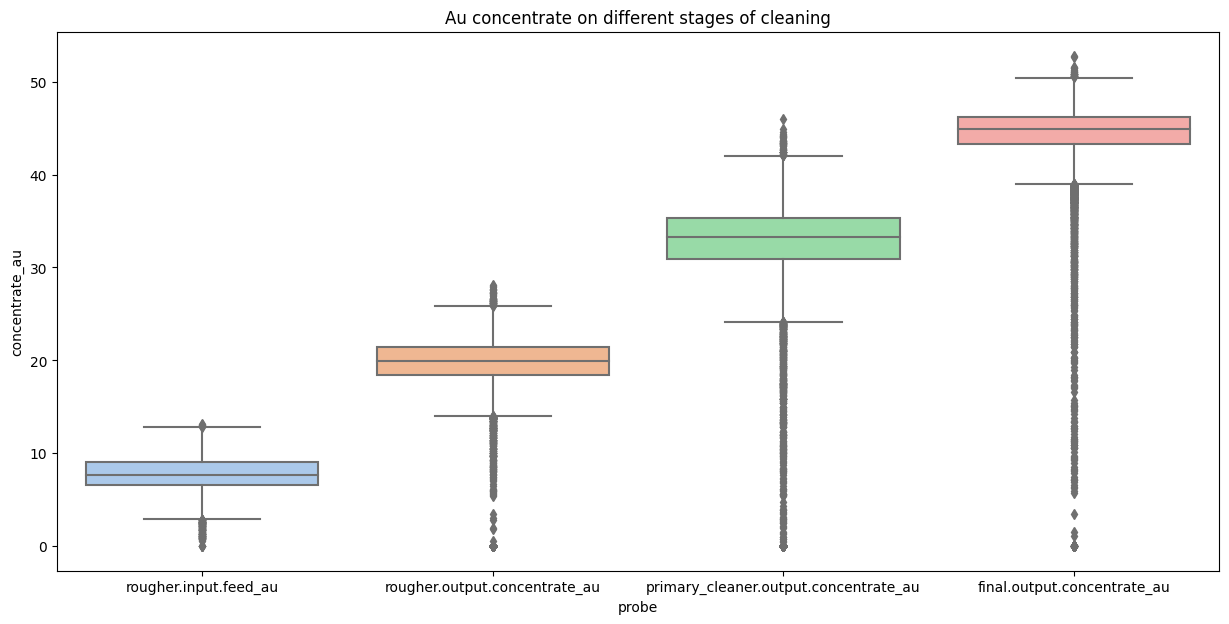

In [13]:
# concentrate_au - the concentration of silver decreases with each step

au_list = ['rougher.input.feed_au', 'rougher.output.concentrate_au'
           , 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
sns.set_palette("pastel")
plt.figure(figsize=(15,7))
sns.boxplot(data=df_train[au_list], order=au_list).set(xlabel='probe', ylabel='concentrate_au')
plt.title('Au concentrate on different stages of cleaning')
plt.show()

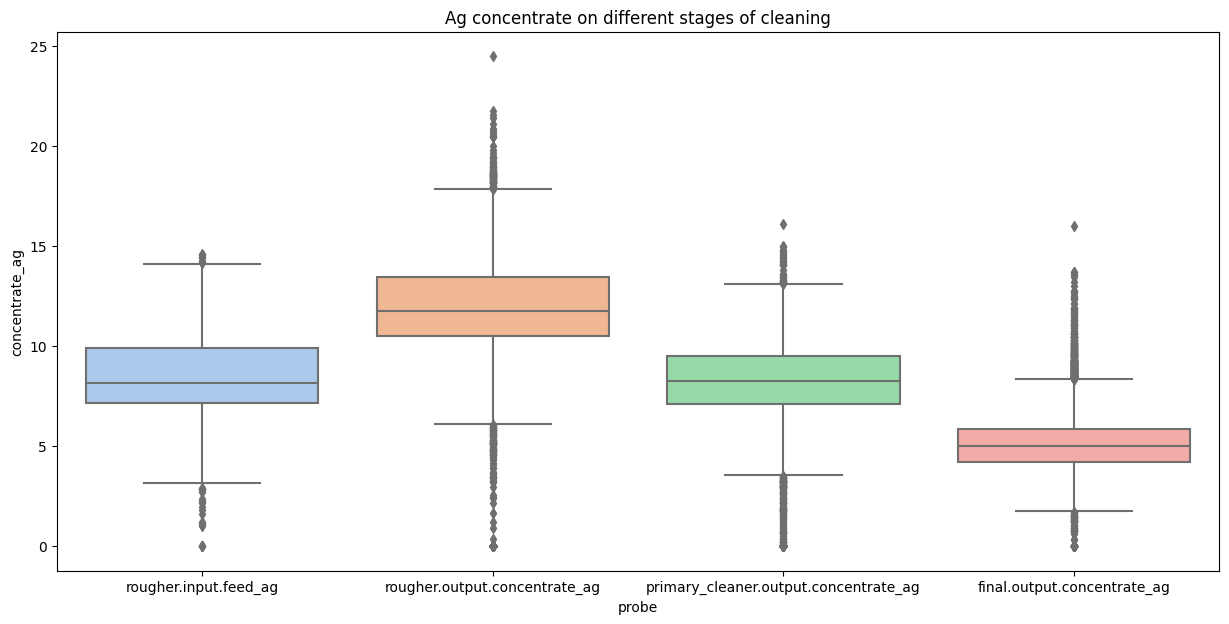

In [14]:
# concentrate_ag - the concentration of silver after the first stage increases, then decreases with each stage

ag_list = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag'
           , 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
sns.set_palette("pastel")
plt.figure(figsize=(15,7))
sns.boxplot(data=df_train[ag_list], order=ag_list).set(xlabel='probe', ylabel='concentrate_ag')
plt.title('Ag concentrate on different stages of cleaning')
plt.show()

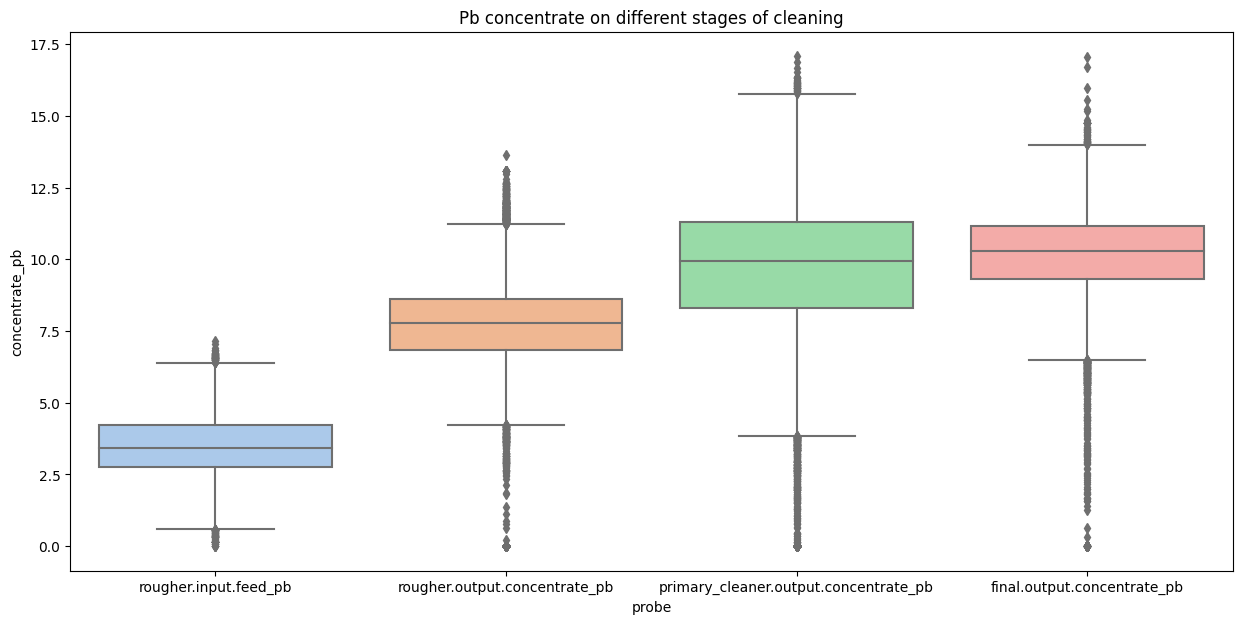

In [15]:
# concentrate_pb - lead concentration increases

pb_list = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb'
           , 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']
sns.set_palette("pastel")
plt.figure(figsize=(15,7))
sns.boxplot(data=df_train[pb_list], order=pb_list).set(xlabel='probe', ylabel='concentrate_pb')
plt.title('Pb concentrate on different stages of cleaning')
plt.show()

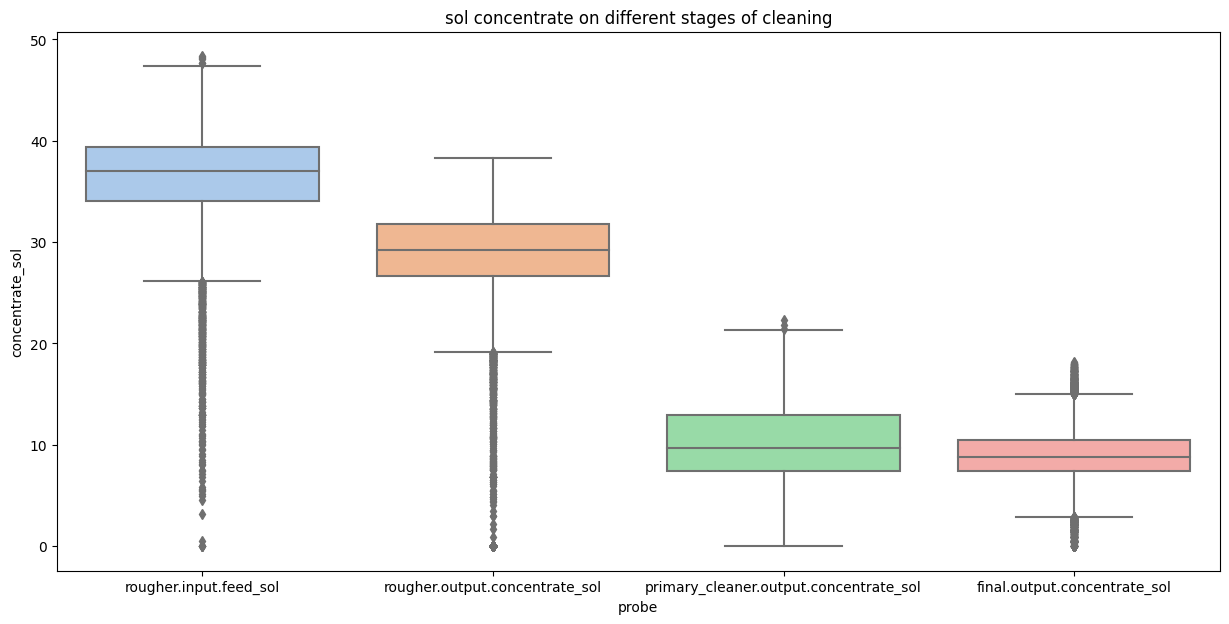

In [16]:
# concentrate_sol - salt concentration decreases with each purification step

sol_list = ['rougher.input.feed_sol', 'rougher.output.concentrate_sol'
            , 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol']
sns.set_palette("pastel")
plt.figure(figsize=(15,7))
sns.boxplot(data=df_train[sol_list], order=sol_list).set(xlabel='probe', ylabel='concentrate_sol')
plt.title('sol concentrate on different stages of cleaning')
plt.show()

**CONCLUSION**

- the concentration of gold and lead increases with each stage of purification, while silver and salts, on the contrary, decrease
- the change in the concentration of these metals corresponds to the technological processes of ore beneficiation
- all indicators at all stages contain data outliers, this may be due to the peculiarities of the technological process or the imperfection of methods for measuring the composition

### size distribution of raw material granules

compare the size distributions of raw material granules on the training and test samples

#### rougher stage

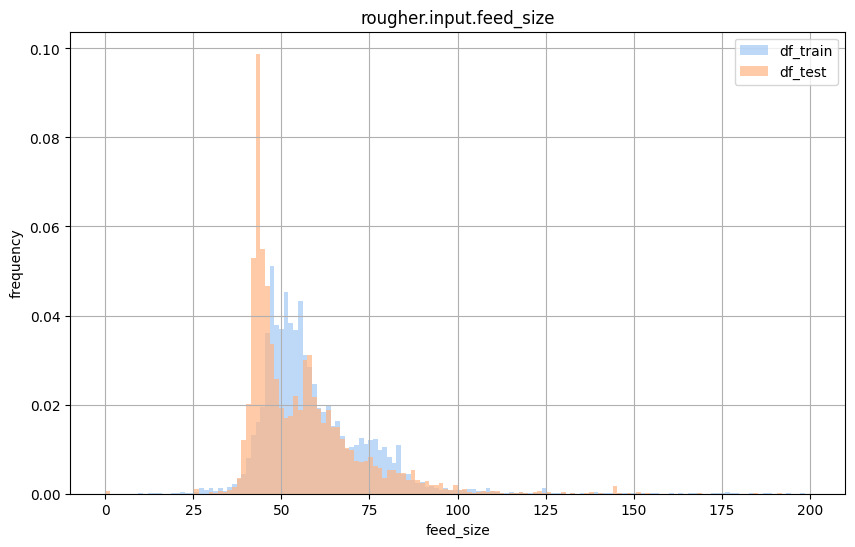

In [17]:
# we see a slight shift of the graph and histogram in the test sample relative to the training one

df_train['rougher.input.feed_size'].hist(density=True, bins=150, figsize=(10,6), range=(0,200), alpha=0.7, label='df_train')
df_test['rougher.input.feed_size'].hist(density=True, bins=150, figsize=(10,6), range=(0,200), alpha=0.7, label='df_test')
plt.title('rougher.input.feed_size')
plt.xlabel('feed_size')
plt.ylabel('frequency')
plt.legend(loc='upper right')
plt.show()

In [18]:
# remove outliers in order to improve the quality of the model
df_train = df_train[df_train['rougher.input.feed_size'] < 125]
df_test = df_test[df_test['rougher.input.feed_size'] < 125]

In [19]:
# calculate the mean and median
print(f"train set: mean = {round(df_train['rougher.input.feed_size'].mean(),2)}, \
median = {round(df_train['rougher.input.feed_size'].median(),2)}")
print()
print(f"test set: mean = {round(df_test['rougher.input.feed_size'].mean(),2)}, \
median = {round(df_test['rougher.input.feed_size'].median(),2)}")

# mean and median differ by 4 and 5 units, we will perform a significance test to find out if this deviation is large

train set: mean = 58.55, median = 55.19

test set: mean = 54.99, median = 50.64


In [20]:
# hypotheses:

# null hypothesis H0: The average sizes of raw material granules on the training and test samples are the same
# alternative hypothesis H1: The average sizes of raw material granules on the training and test samples are NOT the same

# take columns with granule sizes
feed_train = df_train['rougher.input.feed_size'].reset_index(drop=True).dropna()
feed_test = df_test['rougher.input.feed_size'].reset_index(drop=True).dropna()

alpha = .05

# test the hypothesis that the means of two independent populations are equal
results = st.ttest_ind(feed_train, feed_test, equal_var = True)

print('p-value:', results.pvalue)
print()
print('mean value of raw material granule sizes on the training set:', round(feed_train.mean()))
print('mean value of raw material granule sizes on the test set:', round(feed_test.mean()))
print()

if results.pvalue < alpha:
    print("We reject the null hypothesis: \
The average sizes of raw material granules on the training and test samples differ significantly")
else:
    print("It was not possible to reject the null hypothesis:\
The average sizes of raw material granules on the training and test samples do NOT differ significantly")

p-value: 1.5958861047820864e-56

mean value of raw material granule sizes on the training set: 59
mean value of raw material granule sizes on the test set: 55

We reject the null hypothesis: The average sizes of raw material granules on the training and test samples differ significantly


**CONCLUSION**

compared the size distributions of raw material granules on the training and test samples at the flotation stage:
- training sample: mean = 58.55, median = 55.19
- test sample: mean = 54.99, median = 50.64

conducted a test for significance, which showed that the average sizes of raw material granules on the training and test samples differ significantly

this conclusion may affect the evaluation of models

#### primary_cleaner stage

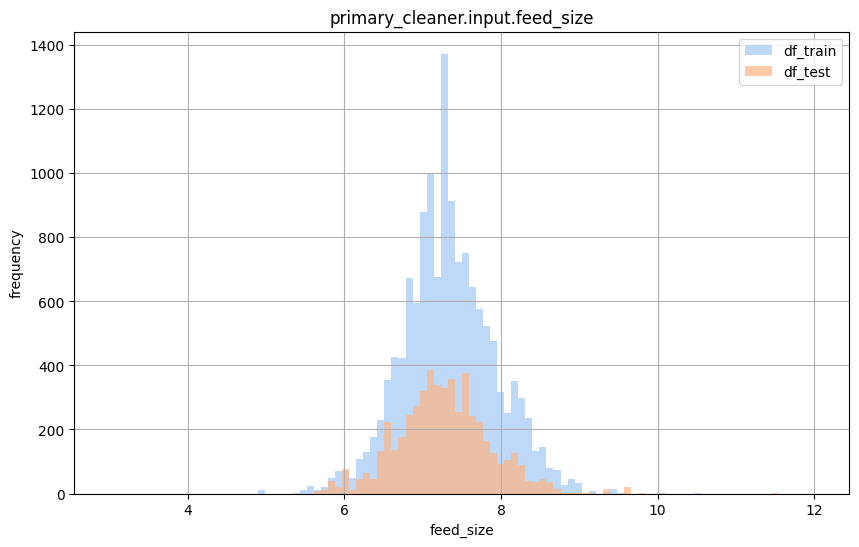

In [21]:
# compare histograms of raw material granule size at the purification stage

df_train['primary_cleaner.input.feed_size'].hist(bins=100, figsize=(10,6), range=(3,12), alpha=0.7, label='df_train')
df_test['primary_cleaner.input.feed_size'].hist(bins=100, figsize=(10,6), range=(3,12), alpha=0.7, label='df_test')
plt.title('primary_cleaner.input.feed_size')
plt.xlabel('feed_size')
plt.ylabel('frequency')
plt.legend(loc='upper right')
plt.show()

# we see that the distributions are similar

**CONCLUSION**

the size distributions of raw material granules on the training and test samples at the stage of primary purification do not differ much

### total concentration of all substances

we will study the total concentration of all substances at different stages: in raw materials, in rough and final concentrates

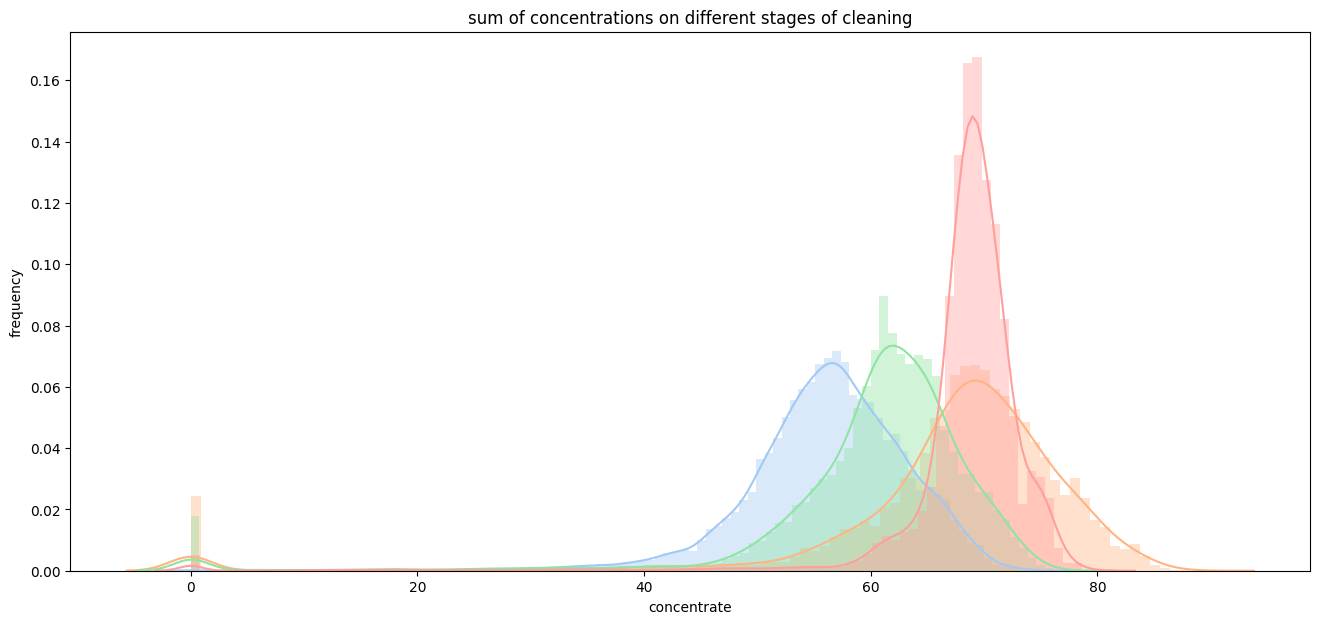

In [22]:
# see the total concentration at different stages

concentration = pd.DataFrame()
concentration['input'] = df_train['rougher.input.feed_ag'] + df_train['rougher.input.feed_pb'] \
                       + df_train['rougher.input.feed_sol'] + df_train['rougher.input.feed_au']
concentration['rougher'] = df_train.filter(like='rougher.output.concentrate', axis=1).sum(axis=1)
concentration['primary_cleaner'] = df_train.filter(like='primary_cleaner.output.concentrate', axis=1).sum(axis=1)
concentration['final'] = df_train.filter(like='final.output.concentrate', axis=1).sum(axis=1)

sns.set_palette("pastel")
plt.figure(figsize=(16,7))
sns.distplot(concentration[['input']], bins=100).set(xlabel='concentrate', ylabel='frequency')
sns.distplot(concentration[['rougher']], bins=100).set(xlabel='concentrate', ylabel='frequency')
sns.distplot(concentration[['primary_cleaner']], bins=100).set(xlabel='concentrate', ylabel='frequency')
sns.distplot(concentration[['final']], bins=100).set(xlabel='concentrate', ylabel='frequency')
plt.title('sum of concentrations on different stages of cleaning')
plt.show()

# see abnormal zero values

In [23]:
# check the number of values close to zero
for i in concentration.columns:
    column = concentration[i]
    count = (column <= 0.1).sum()
    print('count zeros', i, count)

count zeros input 5
count zeros rougher 301
count zeros primary_cleaner 191
count zeros final 58


In [24]:
# remove zero values in columns with concentration
zero_columns_train = list(df_train.filter(like='concentrate', axis=1).columns)
zero_columns_test = list(df_test.filter(like='concentrate', axis=1).columns)

# replace zeros with nan
for i in zero_columns_train:
    df_train[i].mask(df_train[i] <= 0.1 , np.nan, inplace=True)
for i in zero_columns_test:
    df_test[i].mask(df_test[i] <= 0.1 , np.nan, inplace=True)    
    
# drop nan
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [25]:
# check size, removed less than 1% of rows
df_train.shape, df_test.shape

((13433, 86), (5250, 52))

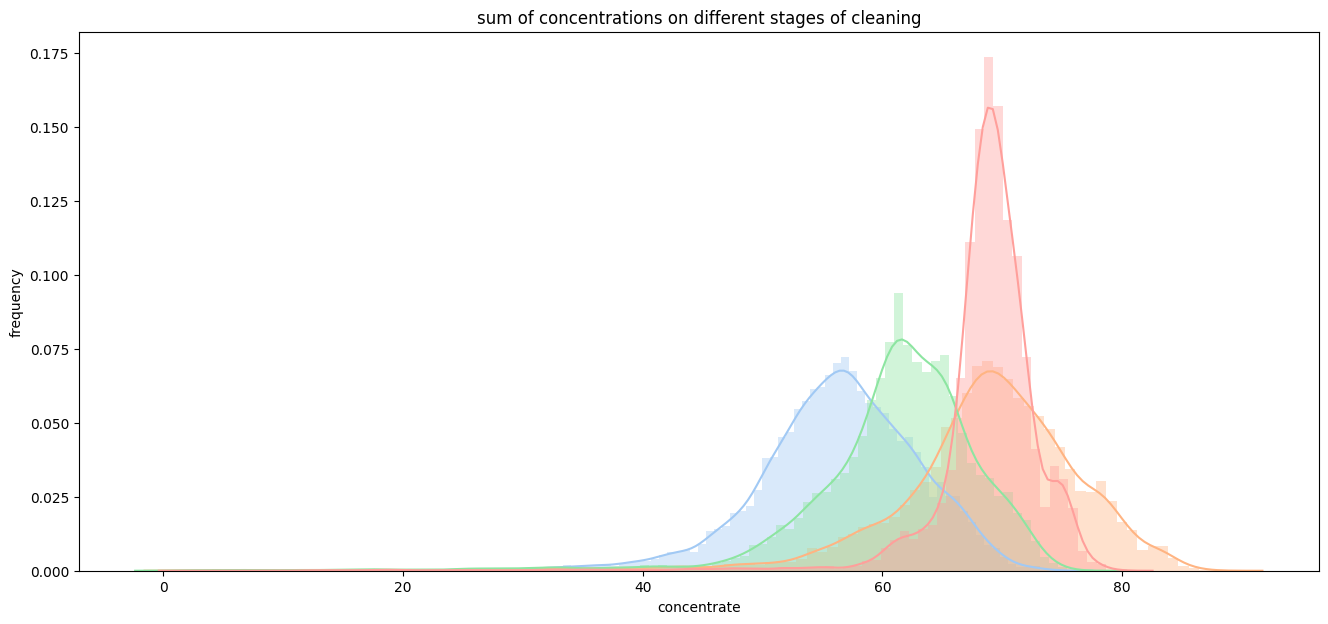

In [26]:
# check the result

concentration = pd.DataFrame()
concentration['input'] = df_train['rougher.input.feed_ag'] + df_train['rougher.input.feed_pb'] \
                       + df_train['rougher.input.feed_sol'] + df_train['rougher.input.feed_au']
concentration['rougher'] = df_train.filter(like='rougher.output.concentrate', axis=1).sum(axis=1)
concentration['primary_cleaner'] = df_train.filter(like='primary_cleaner.output.concentrate', axis=1).sum(axis=1)
concentration['final'] = df_train.filter(like='final.output.concentrate', axis=1).sum(axis=1)

sns.set_palette("pastel")
plt.figure(figsize=(16,7))
sns.distplot(concentration[['input']], bins=100).set(xlabel='concentrate', ylabel='frequency')
sns.distplot(concentration[['rougher']], bins=100).set(xlabel='concentrate', ylabel='frequency')
sns.distplot(concentration[['primary_cleaner']], bins=100).set(xlabel='concentrate', ylabel='frequency')
sns.distplot(concentration[['final']], bins=100).set(xlabel='concentrate', ylabel='frequency')
plt.title('sum of concentrations on different stages of cleaning')
plt.show()

# we do not see abnormal null values

**CONCLUSION**

- studied the total concentration of all substances at different stages: the concentration increases after the flotation stage, then decreases and at the final stage returns to the flotation level
- removed extreme values close to zero

## Model

In [27]:
# write the sMAPE formula, the final metric is the sum of two values:
# - recovery of rough concentrate rougher.output.recovery
# - recovery of final concentrate final.output.recovery

def sMAPE(R_predict, R_valid, F_predict, F_valid):
    rougher = 1/len(R_predict) * np.sum((2 * np.abs(R_valid - R_predict)) / (np.abs(R_predict) + np.abs(R_valid))*100)
    final = 1/len(F_predict) * np.sum((2 * np.abs(F_valid - F_predict)) / (np.abs(F_predict) + np.abs(F_valid))*100)
    sMAPE_final = 0.25 * rougher  +  0.75 * final
    return round(sMAPE_final,2)

In [28]:
# select target features
target_rougher = df_train['rougher.output.recovery']
target_final = df_train['final.output.recovery']

# leave in the training sample only those features that are in the test sample
df_train = df_train.loc[:, df_train.columns.isin(df_test.columns)]

# select features for learning
features_rougher = df_train.filter(like='rougher', axis=1)
features_final = df_train.drop(features_rougher.columns, axis=1)

### model selection

In [29]:
# build a LinearRegression model, evaluate the quality by cross-validation

model_LR = LinearRegression()
R_predict = cross_val_predict(model_LR, features_rougher, target_rougher, cv=5)
F_predict = cross_val_predict(model_LR, features_final, target_final, cv=5)

print('sMAPE for LinearRegression: ', sMAPE(R_predict, target_rougher, F_predict, target_final))

sMAPE for LinearRegression:  8.74


In [30]:
# build a DecisionTreeRegressor model

i = 0
result = pd.DataFrame(columns=['depth', 'sMAPE'])

for depth in range(1, 15, 2):
    model_DTR = DecisionTreeRegressor(random_state=STATE, max_depth=depth)
    R_predict = cross_val_predict(model_DTR, features_rougher, target_rougher, cv=5)
    F_predict = cross_val_predict(model_DTR, features_final, target_final, cv=5)
    result.loc[i] = [depth, sMAPE(R_predict, target_rougher, F_predict, target_final)]
    i += 1

print('sMAPE for DecisionTreeRegressor: \n', result.sort_values('sMAPE').head())

sMAPE for DecisionTreeRegressor: 
    depth  sMAPE
0    1.0   9.31
1    3.0   9.43
2    5.0  10.73
3    7.0  12.27
6   13.0  13.61


In [31]:
# build a RandomForestRegressor model

i = 0
result = pd.DataFrame(columns=['est', 'depth', 'sMAPE'])

for est in range(5, 15, 2):
    for depth in range (1, 5):
        model_RFR = RandomForestRegressor(random_state=STATE, n_estimators=est, max_depth=depth)
        R_predict = cross_val_predict(model_RFR, features_rougher, target_rougher, cv=5)
        F_predict = cross_val_predict(model_RFR, features_final, target_final, cv=5)
        result.loc[i] = [est, depth, sMAPE(R_predict, target_rougher, F_predict, target_final)]
        i += 1

print('sMAPE for RandomForestRegressor: \n', result.sort_values('sMAPE').head())

sMAPE for RandomForestRegressor: 
     est  depth  sMAPE
6   7.0    3.0   8.94
10  9.0    3.0   8.94
2   5.0    3.0   9.02
5   7.0    2.0   9.02
9   9.0    2.0   9.03


**CONCLUSION**

the smallest value of sMAPE = 8.74 was obtained in LinearRegression model, we will choose it for further research

### model testing

In [32]:
# prepare samples for model testing

# extract the features from the test set
features_rougher_test = df_test.filter(like='rougher', axis=1)
features_final_test = df_test.drop(features_rougher_test.columns, axis=1)

# find target features from the total sample for values from the test sample
df_full_test = df_full.query('index in @df_test.index')

# select target features
target_rougher_test = df_full_test['rougher.output.recovery']
target_final_test = df_full_test['final.output.recovery']

In [33]:
# check sample sizes
features_rougher_test.shape, target_rougher_test.shape, features_final_test.shape, target_final_test.shape

((5250, 22), (5250,), (5250, 30), (5250,))

In [34]:
# make predictions

model_LR.fit(features_rougher, target_rougher) 
R_predict = model_LR.predict(features_rougher_test) 

model_LR.fit(features_final, target_final)
F_predict = model_LR.predict(features_final_test)

print('sMAPE of the final model:', sMAPE(R_predict, target_rougher_test, F_predict, target_final_test))

sMAPE of the final model: 9.19


In [35]:
# compare the results with the constant model 
# we take the predictive values equal to the arithmetic mean values of the target features

model_DR = DummyRegressor(strategy='mean')

model_DR.fit(features_rougher, target_rougher)
R_predict = model_DR.predict(features_rougher_test)

model_DR.fit(features_final, target_final)
F_predict = model_DR.predict(features_final_test)

print('sMAPE of the constant model:', sMAPE(R_predict, target_rougher_test, F_predict, target_final_test))

sMAPE of the constant model: 9.71


**CONCLUSION**

sMAPE value on test data = 9.19, the metric did not increase much, this is a good result
constant model sMAPE value = 9.71, so our final model is better

## Conclusion

provided data with the parameters of extraction and purification of gold from ore

**TASK:** to prepare a prototype of a machine learning model for a company that develops solutions for the efficient operation of industrial enterprises. the model should predict the recovery factor for gold from gold ore. the model should help optimize production so as not to launch an enterprise with unprofitable characteristics.

it is necessary to predict the values:
- efficiency of crude concentrate enrichment
- final concentrate enrichment efficiency

quality metric - sMAPE (Symmetric Mean Absolute Percentage Error, "symmetric mean absolute percentage deviation")
    
    
**data preparation:**
- missing values ​​are filled with values ​​from adjacent cells, no duplicates
- in the test sample there are no columns with the product parameter at all stages and the calculated characteristics
- enrichment efficiency calculated correctly

**data analysis**
- the concentration of gold and lead increases with each stage of purification, while silver and salts, on the contrary, decrease
- the change in the concentration of these metals corresponds to the technological processes of ore beneficiation
- all indicators at all stages contain data outliers, this may be due to the peculiarities of the technological process or the imperfection of methods for measuring the composition
- the total concentration of all substances increases after the flotation stage, then decreases and returns to the flotation level at the final stage, extreme values ​​close to zero are removed

raw material granule sizes:
- conducted a test for significance, which showed that *average grain sizes of raw materials* on the training and test samples at the *flotation stage* differ significantly, this conclusion may affect the evaluation of the models
- the size distributions of raw material granules on the training and test samples at the *primary cleaning stage* do not differ much

**MODEL**

- studied models LinearRegression, DecisionTreeRegressor, RandomForestRegressor
- the LinearRegression model was chosen, it showed the smallest value of the metric sMAPE = 8.74 when selecting the model and sMAPE = 9.19 when checking on the test sample
- when compared with the constant model, the final model showed better results (sMAPE in DummyRegressor = 9.71)